# Lightgbm Prediction Model

## Data Cleaning and Preparation

In [18]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
def feature_creation(df):
    # Adding features
    df["renewed"] = df.renewal_status.isin(["Renewed", "Transfered"]).astype(int)
    df["expiry_date"] = pd.to_datetime(df["expiry_date"])

    # Create mxdomain_cat feature
    extensions = df.mxdomain.dropna().str.extract(".*?((?:\..*)+)")[0]
    vc = extensions.value_counts(normalize=True)
    common_extensions = vc[vc > 0.01].index
    df["mxdomain_cat"] = np.nan
    df.loc[df.mxdomain.isna(), "mxdomain_cat"] = "missing"
    df.loc[df.mxdomain == df.nameserver, "mxdomain_cat"] = "nameserver"
    df.loc[df.mxdomain == df.domain, "mxdomain_cat"] = "domain"
    rlower = df.reseller.str.lower()
    df.loc[df.mxdomain == rlower, "mxdomain_cat"] = "reseller"
    for extension in common_extensions:
        df.loc[df.mxdomain == rlower + extension, "mxdomain_cat"] = "reseller"

    # Create months since start feature
    df["months_since_start"] = 12 * (df.expiry_date.dt.year - df.expiry_date.min().year) + (df.expiry_date.dt.month - df.expiry_date.min().month)

    return df

def convert_dtypes(df):
    # Convert string to categorical
    cat_cols = df.columns[df.dtypes == "O"]
    df[cat_cols] = df[cat_cols].astype("category")


    # Convert Pandas int to float
    int_cols = df.columns[df.dtypes == "Int64"]
    df[int_cols] = df[int_cols].astype(float)

    # Convert bool to float
    bool_cols = df.columns[df.dtypes == "boolean"]
    df[bool_cols] = df[bool_cols].astype(float)

    return df


In [7]:
read_bq = False  # Whether to read in table from bq or local

# Where to read from/save to
datapath = Path("/home/jupyter/Domains_202003/data/output/dp_datapull_20220930")

if read_bq:

    # Change these as necessary
    # proj_name = "myriad-303821"
    # dataset = "expiry"
    # table_name = "expiry_20170101_20220930_test"
    proj_name = "radixbi-249015"
    dataset = "prediction_vendors"
    table_name = "expiry_data_with_npv_and_dp_data_vw"

    # Read in data
    query = f"select * from `{dataset}.{table_name}`"
    df = pd.read_gbq(
        query, project_id=proj_name, progress_bar_type="tqdm_notebook",
        use_bqstorage_api=True,
    )
    
    # Generate features
    df = feature_creation(df)

    # Save for future use
    df.to_feather(datapath / "expiry_data_with_npv_and_dp_data_vw.ftr")
    
else:
    # Read in local file
    df = pd.read_feather(datapath / "expiry_20170101_20220930_test.ftr")


## Train Model

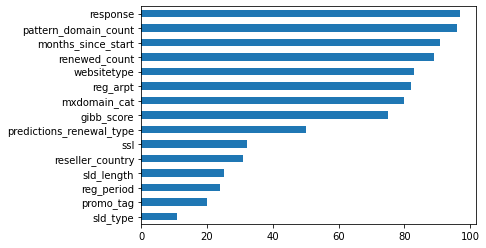

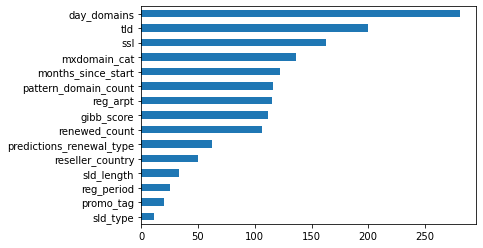

,domain,expiry_date,tld,reseller,renewed_count,renewal_status,renewed,feature_set,model,prediction
95,heartdisease.store,2022-04-03,store,CHENGDU WEST,1,Not Renewd,0,all,lightgbm,0.030653
102,gzworker.site,2022-06-30,site,CHENGDU WEST,1,Not Renewd,0,all,lightgbm,0.024253
157,ybkers.site,2021-12-09,site,CHENGDU WEST,1,Not Renewd,0,all,lightgbm,0.024481
175,allbirdsks.store,2022-01-07,store,CHENGDU WEST,1,Not Renewd,0,all,lightgbm,0.036784
247,workfor-is.site,2022-08-11,site,CHENGDU WEST,1,Not Renewd,0,all,lightgbm,0.022887


In [20]:
# Define features
non_dp_features = [
    'renewed_count', 'promo_tag', 'tld', 'reseller', 'reseller_country', 'reg_period',
    'reg_arpt', 'gibb_score', 'pattern_domain_count', 'day_domains', 'sld_length', 'sld_type',
    'sld_type2', 'predictions_renewal_type', 'ssl', 'mxdomain_cat', 'months_since_start'
]
dp_features = ["country", "economy_footprint", "response", "websitetype", "hosting_country"]
verbose = 1

# Columns to save to bq
rel_cols = ["domain", "expiry_date", "tld", "reseller", "renewed_count", "renewal_status", "renewed", "feature_set", "model", "prediction"]
pred_df_list = []
for dp in [True, False]:
    features = list(non_dp_features)
    if dp:
        features += dp_features

    # Select features and fix data types
    X = df[features].copy()
    X = convert_dtypes(X)

    # train test parameters
    end_train = "2021-01-01"
    end_test = "2023-07-01"
    train_months = 18
    start_train = pd.to_datetime(end_train) - pd.DateOffset(months=train_months)

    # split train and test
    train_mask = (df.expiry_date >= start_train) & (df.expiry_date < end_train)
    test_mask = (df.expiry_date >= end_train) & (df.expiry_date < end_test)
    X_train = X[train_mask].copy()
    y_train = df.loc[train_mask, "renewed"].copy()
    X_test = X[test_mask].copy()
    y_test = df.loc[test_mask, "renewed"].copy()
    preds_df = df[test_mask].copy()

    # Train model
    mc = [1 if col == "renewed_count" else 0 for col in features]
    clf = lgb.LGBMClassifier(n_jobs=-1, mc=mc, mc_method="advanced")
    clf.fit(X_train, y_train)

    # Plot importances
    if verbose > 0:
        fi = pd.Series(clf.feature_importances_, index=features)
        fi.sort_values().iloc[:15].plot.barh()
        plt.show()

    # Make and save predictions
    preds_df["prediction"] = clf.predict_proba(X_test)[:, 1]
    preds_df["feature_set"] = ["non_dp", "all"][dp]
    preds_df["model"] = "lightgbm"

    pred_df_list.append(preds_df[rel_cols])

all_preds = pd.concat(pred_df_list)
all_preds.head()

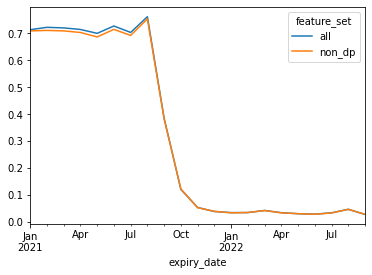

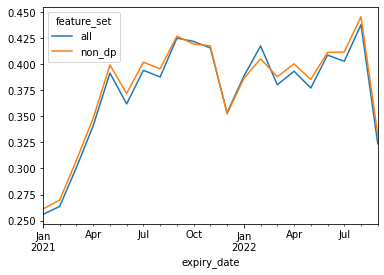

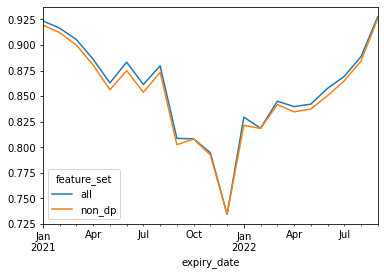

In [22]:
# Validation
from sklearn.metrics import average_precision_score, log_loss, roc_auc_score

mets = [average_precision_score, log_loss, roc_auc_score]
for met in mets:
    f = lambda x: met(x.renewed, x.prediction)
    g = all_preds.groupby([pd.Grouper(key="expiry_date", freq="MS"), "feature_set"]).apply(f)
    piv = g.unstack()
    piv.plot()
    plt.show()

## Save Predictions

In [23]:
all_preds.to_gbq(
    "expiry.preds_lightgbm_2021-01-01_2022-09-30",
    project_id = "myriad-303821",
    if_exists = "replace",
)

100%|██████████| 1/1 [00:00<00:00, 5289.16it/s]
